In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.wkt import loads
import geotable
import os

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Camera Dataset: `os.path.dirname(os.path.dirname(path))+'/CapstoneData/amnesty_camera_counts_per_intersections.csv'`

 * Hikvision Camera Dataset: `../Data/NYC_Surveillance_Map_Hikvision.csv`


 **Shapefiles**

 * Brooklyn Census Blocks: `../Data/census blocks only Brooklyn.csv`

 * Brooklyn Census Tracts: `../Data/census tracts Brooklyn.csv`

 * Brooklyn Zip Codes: `../Data/zip code Brooklyn.csv`

#### Output Files:

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`

In [2]:
#load camera data
path = os.getcwd()
parent = os.path.dirname(os.path.dirname(path))
amnesty = pd.read_csv('../Data/amnesty_camera_counts_per_intersections.csv')
hikvision = pd.read_csv('../Data/NYC_Surveillance_Map_Hikvision.csv', index_col = 0)

In [3]:
amnesty.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,attached_unknown_agreement,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate
0,--48RnFczF55WcDFpy5y_Q,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.870564,-73.869327,POINT (-73.86932652339482 40.87056425110688),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-08
1,--T2iuvfxXJrzbgD7R3W-g,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,2 vs 1,Unanimous,Unanimous,Unanimous,40.669099,-73.762447,POINT (-73.76244689609075 40.6690985670363),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-10
2,--VGAsqPgTXxgZFXuhuhbg,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.766790,-73.771211,POINT (-73.7712107859631 40.76679030231237),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-11
3,--YJY0GGvay_3W_O5ObeNQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.554253,-74.201603,POINT (-74.20160298846051 40.55425348634071),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09
4,--fUkaf5nn1-bm4KiJ9pVA,1,0,1,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.611084,-74.162803,POINT (-74.16280280196275 40.61108412672856),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09


In [4]:
hikvision.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt
0,100.12.128.86,40.630798,-74.098297,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.09829712 40.63079834 0)
1,100.12.139.126,40.604191,-74.107681,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10768127 40.60419083 0)
2,100.12.139.79,40.605530,-74.102753,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10275269 40.60552979 0)
3,100.12.141.104,40.627338,-74.103592,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10359192 40.62733841 0)
4,100.12.152.177,40.624729,-74.094543,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.09454346 40.62472916 0)


In [5]:
#load shapefiles
nyc_blks = pd.read_csv('../Data/2020_Census_Blocks_-_Tabular.csv')
nyc_tracts = pd.read_csv('../Data/2020_Census_Tracts_-_Tabular.csv')
nyc_blks.head()

,the_geom,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.03995040788483 40.70089063...,1000,1,Manhattan,100,10001001000,360610001001000,6627.858318,1.204255e+06
1,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1001,1,Manhattan,100,10001001001,360610001001001,4395.190183,6.401664e+05
2,MULTIPOLYGON (((-73.98511406569527 40.71378675...,1000,1,Manhattan,201,10002011000,360610002011000,1569.384823,1.292763e+05
3,MULTIPOLYGON (((-73.98505770255532 40.71307771...,1001,1,Manhattan,201,10002011001,360610002011001,1594.262855,1.393604e+05
4,MULTIPOLYGON (((-73.98495042073655 40.71235553...,2000,1,Manhattan,201,10002012000,360610002012000,2055.295961,2.633084e+05


In [6]:
nyc_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1.00,1,Manhattan,100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,MULTIPOLYGON (((-73.98449647076764 40.70950966...,2.01,1,Manhattan,201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,MULTIPOLYGON (((-73.99022012669926 40.71440493...,6.00,1,Manhattan,600,1000600,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,MULTIPOLYGON (((-73.9883662631772 40.716445702...,14.01,1,Manhattan,1401,1001401,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,MULTIPOLYGON (((-73.98507342254645 40.71908329...,14.02,1,Manhattan,1402,1001402,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


In [7]:
# Convert the 'the_geom' column from WKT format to Shapely geometry objects
nyc_blks['the_geom'] = nyc_blks['the_geom'].apply(loads)
nyc_tracts['the_geom'] = nyc_tracts['the_geom'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
blks_gdf = gpd.GeoDataFrame(nyc_blks, geometry='the_geom', crs = '4326')
tracts_gdf = gpd.GeoDataFrame(nyc_tracts, geometry='the_geom', crs = '4326')

In [8]:
blks_gdf.head()

,the_geom,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((-74.03995 40.70089, -74.03945 ...",1000,1,Manhattan,100,10001001000,360610001001000,6627.858318,1.204255e+06
1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1001,1,Manhattan,100,10001001001,360610001001001,4395.190183,6.401664e+05
2,"MULTIPOLYGON (((-73.98511 40.71379, -73.98706 ...",1000,1,Manhattan,201,10002011000,360610002011000,1569.384823,1.292763e+05
3,"MULTIPOLYGON (((-73.98506 40.71308, -73.98544 ...",1001,1,Manhattan,201,10002011001,360610002011001,1594.262855,1.393604e+05
4,"MULTIPOLYGON (((-73.98495 40.71236, -73.98485 ...",2000,1,Manhattan,201,10002012000,360610002012000,2055.295961,2.633084e+05


In [9]:
print(len(blks_gdf), len(tracts_gdf))

37589 2325


In [10]:
bk_blks = blks_gdf[blks_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_tracts = tracts_gdf[tracts_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)

In [11]:
print(len(bk_blks),len(bk_tracts))

9769 804


<AxesSubplot:>

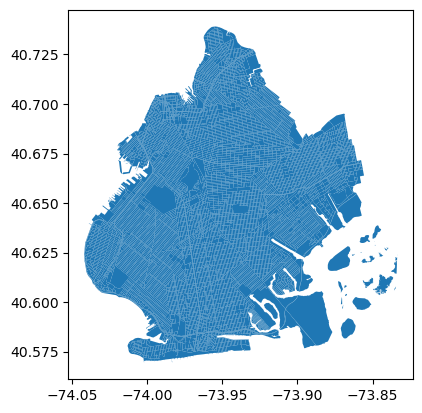

In [12]:
#plot
bk_blks.plot()

<AxesSubplot:>

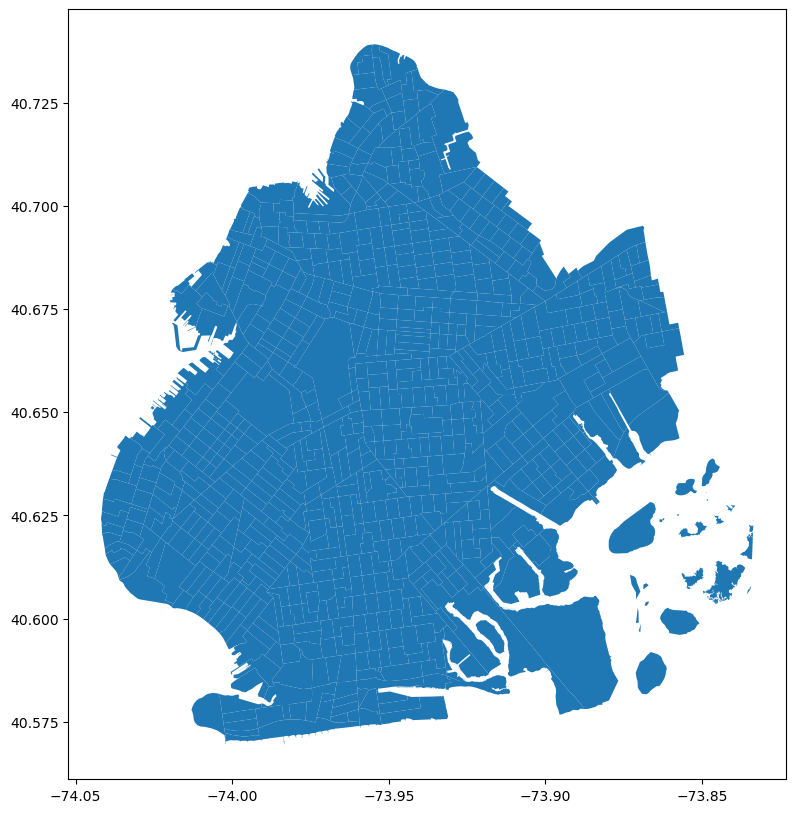

In [13]:
bk_tracts.plot(figsize = (10,10))

In [14]:
#get the boundary geometry
from shapely.ops import unary_union

boundary = unary_union(bk_tracts.geometry)
bndy_gdf = boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs='EPSG:4326')

<AxesSubplot:>

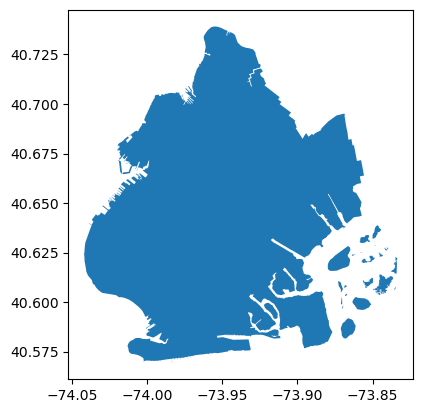

In [15]:
bndy_gdf.plot()

In [16]:
#covert the geometry points in the camera datasets and filter via spatial join
from shapely.geometry import Point

# Create a new column with Point geometries based on the 'lat' and 'lon' columns
geometry = [Point(xy) for xy in zip(amnesty['Long'], amnesty['Lat'])]

# Create a GeoDataFrame with the 'geometry' column and CRS set to EPSG:4326
amnesty_gdf = gpd.GeoDataFrame(amnesty, geometry=geometry, crs='EPSG:4326')
amnesty_gdf.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry
0,--48RnFczF55WcDFpy5y_Q,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.870564,-73.869327,POINT (-73.86932652339482 40.87056425110688),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-08,POINT (-73.86933 40.87056)
1,--T2iuvfxXJrzbgD7R3W-g,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.669099,-73.762447,POINT (-73.76244689609075 40.6690985670363),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-10,POINT (-73.76245 40.66910)
2,--VGAsqPgTXxgZFXuhuhbg,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,40.766790,-73.771211,POINT (-73.7712107859631 40.76679030231237),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.77121 40.76679)
3,--YJY0GGvay_3W_O5ObeNQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.554253,-74.201603,POINT (-74.20160298846051 40.55425348634071),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09,POINT (-74.20160 40.55425)
4,--fUkaf5nn1-bm4KiJ9pVA,1,0,1,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.611084,-74.162803,POINT (-74.16280280196275 40.61108412672856),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09,POINT (-74.16280 40.61108)


In [17]:
#spatial join
# Conduct a spatial join between 'amnesty_gdf' and the boundary polygon
amnesty_bk = gpd.sjoin(amnesty_gdf, bndy_gdf, how='inner', predicate='within')
print(len(amnesty_gdf),len(amnesty_bk))

43406 10377


In [18]:
#repeat for the hikvision df
hikvision['wkt'] = hikvision['wkt'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
hikvision_gdf = gpd.GeoDataFrame(hikvision, geometry='wkt', crs = '4326')
hikvision_bk = gpd.sjoin(hikvision_gdf, bndy_gdf, how='inner', predicate='within')
print(len(hikvision_gdf),len(hikvision_bk))

16535 5996


In [19]:
amnesty_bk.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry,index_right
6,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663),0
8,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983),0
9,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289),0
10,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276),0
14,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540),0


In [20]:
hikvision_bk = hikvision_bk.drop(columns = ['index_right']).reset_index(drop = True)
hikvision_bk

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt
0,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99064 40.69460 0.00000)
1,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99064 40.69460 0.00000)
2,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99064 40.69460 0.00000)
3,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99064 40.69460 0.00000)
4,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.98780 40.70246 0.00000)
...,...,...,...,...,...,...,...
5991,148.75.209.9,40.678120,-73.962303,11238.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-73.96230 40.67812 0.00000)
5992,148.75.245.80,40.676159,-73.964401,11238.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-73.96440 40.67616 0.00000)
5993,151.205.102.146,40.683998,-73.967743,11238.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-73.96774 40.68400 0.00000)
5994,162.83.196.103,40.676159,-73.964401,11238.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-73.96440 40.67616 0.00000)


In [21]:
amnesty_bk = amnesty_bk.drop(columns = ['index_right']).reset_index(drop = True)
amnesty_bk

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry
0,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663)
1,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983)
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289)
3,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276)
4,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10372,zxukN7aaPIXjr_-PKVYCaQ,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,40.659942,-73.891606,POINT (-73.89160582393718 40.65994186330771),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-08,POINT (-73.89161 40.65994)
10373,zy9v2PJ7cJjmw-Twze2hHQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.690835,-73.996204,POINT (-73.99620417523222 40.69083526983461),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.99620 40.69084)
10374,zyrnhbyzYA_xmqRo4yFpEg,1,0,1,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.660964,-73.960515,POINT (-73.96051461519275 40.66096409427961),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-73.96051 40.66096)
10375,zzGi76xVLj80tO3uEsFA4g,3,0,3,0,0,0,0,All disagree,2 vs 1,...,Unanimous,2 vs 1,Unanimous,40.593755,-73.960782,POINT (-73.96078164398766 40.5937550308211),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-10,POINT (-73.96078 40.59376)


In [22]:
#amnesty_bk.to_csv('../Data/amnesty_international_cameras_brooklyn.csv')

In [23]:
#hikvision_bk.to_csv('../Data/hikvision_camera_brooklyn.csv')

In [28]:
amnesty_bk_agg = amnesty_bk.groupby(['Lat', 'Long']).agg(
        {"n_cameras_median": "sum", 
         "n_cameras_agreement": "sum"}
).reset_index()

In [29]:
amnesty_bk_agg

,Lat,Long,n_cameras_median,n_cameras_agreement
0,40.572668,-73.998074,0,Unanimous
1,40.572700,-73.996922,1,All disagree
2,40.572729,-73.996067,3,All disagree
3,40.572730,-73.999129,3,All disagree
4,40.572773,-73.994897,1,All disagree
...,...,...,...,...
10372,40.737492,-73.953111,0,Unanimous
10373,40.737882,-73.955560,2,All disagree
10374,40.737909,-73.953151,0,Unanimous
10375,40.737929,-73.955385,2,2 vs 1


In [27]:
# Aggregate counts by geographic location
hikvision_bk_agg = hikvision_bk.groupby(['Latitude', 'Longitude']).sum()
hikvision_bk_agg

,,Zip_Code
Latitude,Longitude,
40.572201,-73.994820,11224.0
40.572769,-73.996498,11224.0
40.574089,-73.990791,33672.0
40.574409,-73.995262,11224.0
40.574810,-74.001198,11224.0
...,...,...
40.733780,-73.958229,11222.0
40.734291,-73.956627,11222.0
40.734489,-73.958351,11222.0
